In [60]:
%matplotlib inline
DEFAULT_FIGSIZE = (12, 8)

import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia import lidar
from antlia import util
from antlia import plot_braking as braking
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
rid = 3 # rider id
tid = 12 # trial id

# load records without syncing
records = lidar.load_records(sync=False)

# remove unused records
record = records[rid]

# sync only record of interest
record.sync()
record._calculate_trials()

trial = record.trial[tid]

Unable to determine range 2
Unable to determine range 1


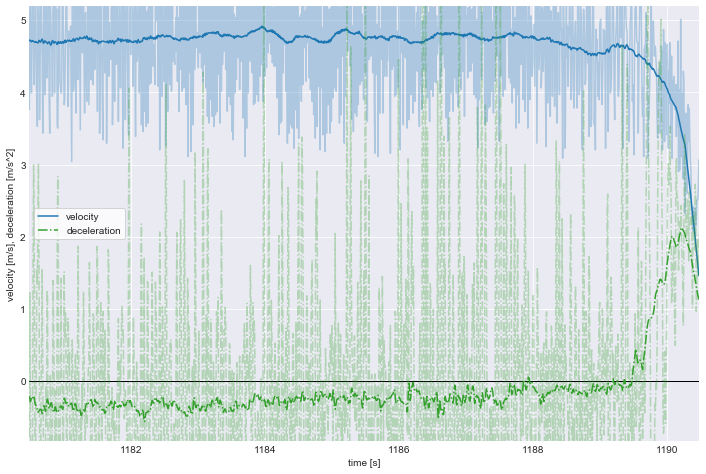

In [70]:
plt.close('all')
fig, ax = braking.plot_trial_braking_event(trial.data)

# remove braking region
[child.remove() for child in ax.get_children()
 if isinstance(child, mpatches.Polygon)]

for l in ax.get_lines()[5:]:
    # remove best fit line
    l.remove()

lines = ax.get_lines()

# change deceleration plots to use a different linestyle
lines[1].set_linestyle('-.')
lines[3].set_linestyle('-.')
    
# update legend labels
lines[0].set_label('velocity')
lines[1].set_label('deceleration')
ax.legend()

ax.set_ylabel('velocity [m/s], deceleration [m/s^2]')

# change x limits
t = lines[0].get_xdata()
ax.set_xlim((t[0], t[-1]))

plt.show()

minima frequencies: [ 0.18395879  1.28771155  1.60963944  1.83958793]


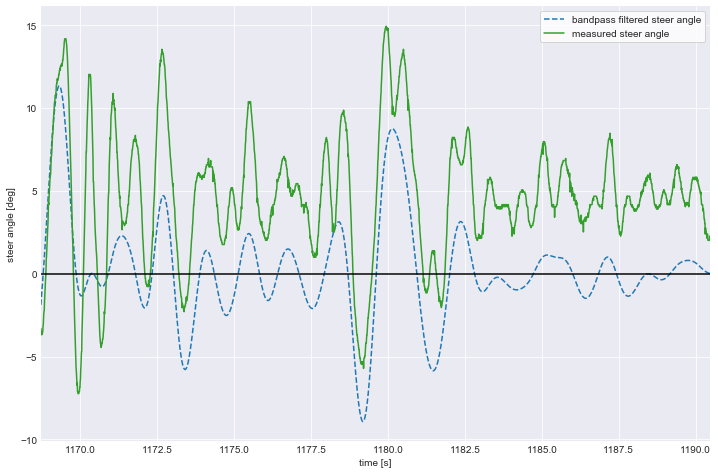

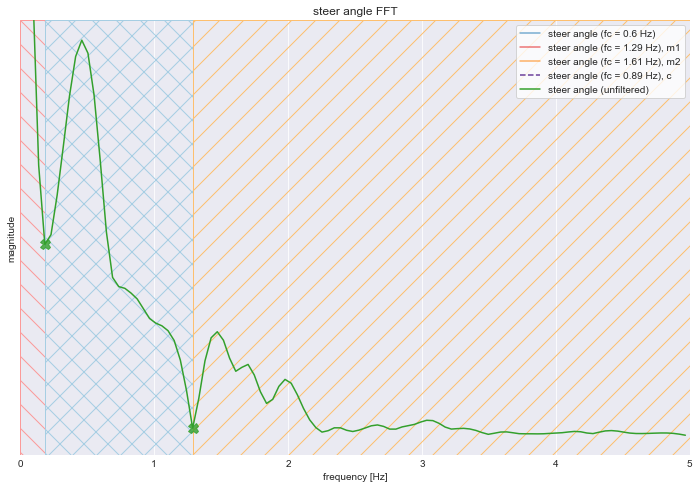

In [62]:
plt.close('all')
colors = sns.color_palette('Paired', 10)

cutoff, (freq, xf), minima = trial.steer_angle_cutoff(True)
print('minima frequencies:', freq[minima])

axes = [plt.subplots()[1] for i in range(2)]
trial.plot_steer_angle_filter_calculation(ax=axes)

for i, l in enumerate(axes[0].get_lines()):
    if i < 3 or i > 4:
        # filtered steer angle, measured steer angle
        l.remove()
    else:
        l.set_color(colors[i - 3])
        # convert angles from radians to degrees
        ydata = l.get_ydata()
        l.set_ydata(180/np.pi*ydata)
                
for i, l in enumerate(axes[1].get_lines()):
    if i != 4:
        # measured steer angle
        l.remove()
    else:
        l.set_color(colors[i - 3])
        
lines = axes[0].get_lines()
lines[0].set_color(colors[1])
lines[1].set_color(colors[3])
lines[0].set_label('bandpass filtered steer angle')
lines[1].set_label('measured steer angle')
    
lines = axes[1].get_lines()
lines[0].set_color(colors[3])
lines[0].set_label('measured steer angle')

axes[0].axhline(0, color='black')

axes[1].plot(freq[minima][:2], xf[minima][:2],
             'X',
             label='steer angle spectrum local minima',
             color=colors[3],
             markersize=10, alpha=0.8)

axes[1].axvspan(0, freq[minima[0]],
                label='region 1',
                hatch='\\',
                fill=False,
                color=colors[4])
axes[1].axvspan(freq[minima[0]], freq[minima[1]],
                label='region 2',
                hatch='X',
                fill=False,
                color=colors[0])
axes[1].axvspan(freq[minima[1]], 5,
                label='region 3',
                hatch='/',
                fill=False,
                color=colors[6])
    
axes[0].legend()
axes[0].set_xlim((trial.data.time[0], trial.data.time[-1]))
axes[1].set_xlim((0, 5))

axes[0].set_ylabel('steer angle [deg]')

# update axes[0] y limits after conversion from rad to deg
axes[0].relim()
axes[0].autoscale_view()

# remove y ticks
axes[1].set_ylabel('magnitude')
axes[1].get_yaxis().set_ticks([])

plt.show()